# Demo version of FuSL for volumetric data.

This demo version should serve as a template to run fusion searchlight (FuSL) on your own data. This pipline consists of two steps to prepare the data for FuSL. In the first step we load the datafiles and store it in a pandas dataframe (running the `load_fusl_cifti_data` function). In a next step we generate a numpy array and labels from this dataframe, which serve as inputs for FuSL (running the `prepare_fusl_data` function). There are three possibilities where you can enter your own data into this workflow:

- You can either structure and name your data files in the same manner as in this example in the `./data` directory
- Or you can generate a pandas dataframe which has the same structure as `input_df`, including the matrix contaning searchlight neighborhoods (`neigh_adj`) (see `./utils/compute_neighborhoods.py`)
- Or you can generate a numpy array (`X`) and labels (`y`) containing your data, including an adjacency matrix contaning the fusion searchlight neighborhoods (`fusl_adj`)

The following script utilizes artificial data in the MNI152 standard space in nifti format. You can alternatively run FuSL on your data in cifti format using the other demo (`FuSL_demo_surf.ipynb`) provided in this repository.

In [ ]:
# Clone repository.
!git clone https://github.com/simonvino/FuSL.git
%cd ./FuSL/

In [ ]:
# Install some additional packages.
!pip install hcp_utils nilearn mne

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from nilearn import plotting

from utils.tfce_stats import tfce_stats
from fusl.fusion_search_light import fusion_search_light, compute_importance_maps
from utils.load_and_prepare import load_fusl_nifti_data, prepare_fusl_data, reshape_3d_img
from utils.compute_neighborhoods import mask_adjacency_mni

## Load the data.
First we would like to load our datafiles and store it in a DataFrame, in which the different information sources are stored in the columns. 
We can therefore use the `load_fusl_nifti_data` function, which assumes our datafiles have the following structure:

├── nifti <br>
│   ├── grp-1 <br>
│   │   ├── source-1_sub-01_ses-1_grp-1.nii <br>
│   │   ├── source-1_sub-02_ses-1_grp-1.nii <br>
│   │   ├── source-1_sub-03_ses-1_grp-1.nii <br>
│   │   ├── ... <br>

├── grp-2 <br>
│   │   ├── source-1_sub-01_ses-1_grp-2.nii <br>
│   │   ├── source-1_sub-02_ses-1_grp-2.nii <br>
│   │   ├── source-1_sub-03_ses-1_grp-2.nii <br>
│   │   ├── ... <br>

As an input we have to provide the path the the directory (`data_dir`), the names of the group directories (`groups`), and the names of the sources (`sources`). This function then additionally generates a matrix containing the neighborhoods of searchlights (`neigh_adj`) with a specified radius (`radius`). These neighborhoods are computed based on the nilearn grey matter mask.

In [2]:
data_dir = './data/nifti/'
groups = ['grp-1', 'grp-2']
sources = ['source-1', 'source-2', 'source-3']

input_df, neigh_adj, mask = load_fusl_nifti_data(data_dir=data_dir,
                                                 groups=groups, 
                                                 sources=sources, 
                                                 world_space=True,
                                                 radius=5,
                                                 verbose=False)

input_df.head(5)  # Visualize dataframe.

,sub,group,source-1,source-2,source-3
0,sub-01,grp-1,"[-2.859687985885645, 0.4242070257218908, 1.033...","[-0.6240493418227441, 0.25074171801912926, -0....","[0.7003126013272527, -0.9710767342287039, -0.2..."
1,sub-02,grp-1,"[0.44769180324956237, 0.25828414931496696, -0....","[0.6537923001549977, -1.3014844142803987, -1.0...","[0.02452741501481612, -0.578122998763228, -0.2..."
2,sub-03,grp-1,"[1.568643246019549, -0.0948781514725051, 0.058...","[0.37956014434849805, -1.654914219870223, 0.83...","[0.12887174110591834, 0.15358711716584522, 0.5..."
3,sub-04,grp-1,"[-1.473200655018006, -0.11812300713577233, -1....","[-2.620726719933812, -1.636315307690616, -0.33...","[2.2211957222605743, -0.5826742669195435, -0.5..."
4,sub-05,grp-1,"[-0.27285668060648677, 0.7216513303979794, -0....","[-1.0445552582342301, -0.677562463064241, 0.85...","[0.21468996078387187, -0.027953373622900728, -..."


## Format the data.

We then convert the data in our DataFrame `input_df` into a numpy array `X` and generate the group labels `y` to train the SL classifier. The features of different sources are concatenated in `X`, so `X` has the shape: (number_of_samples, number_of_sources * number_of_vertices). <br>
Also for each source we duplicate and horizontally concatenate our neighborhood adjacency matrix (`neigh_adj`), so that we get an adjacency matrix for our fusion searchlight (`fusl_adj`) with shape: (number_of_vertices, number_of_sources * number_of_vertices), where rows of `fusl_sl` contain SLs that simultaneously collect values from all sources.

In [3]:
# Specify sources used in FuSL.
sl_sources = ['source-1', 'source-2', 'source-3']

# Generate inputs for FuSL.
X, y, fusl_adj = prepare_fusl_data(input_df=input_df, 
                                   sources=sl_sources,
                                   groups=groups,
                                   neigh_adj=neigh_adj)

Avgerage number of vertices within SLs: 17.1
X has shape: (60, 157530), FuSL adjacency matrix has shape: (52510, 157530).


## Run FuSL.
Now we have prepared our data and can set up our searchlight analysis.

In [ ]:
# Define estimator.
clf = SVC(kernel='rbf')  # We can use any sci-kit learn classifier here.
estimator = make_pipeline(StandardScaler(), clf)  # Add standard scaling.

# Define cross-validation scheme.
cv = RepeatedStratifiedKFold(n_splits=10, 
                             n_repeats=1,
                             random_state=42)

# Run search light.
results = fusion_search_light(X=X, 
                              y=y, 
                              estimator=estimator,
                              A=fusl_adj, 
                              cv=cv, 
                              n_jobs=20,
                              n_permutations=0, 
                              shap=True)

## Visualize results.
Once we finished running our analysis we can visualize the decoding accuracy and the impact of each source across the cortex. We first visualize the decoding accuracy here. Because the artificial data was defined only on the left hemisphere, we only use the meshes of the left cortex. We then threshold the decoding accuracy, using an arbitrary threshold (`acc_threshold`) of 75%. Usually we would here threshold the accuracy maps using permutation testing to find statistically significant accuracies, but because this is computationally more expensive we use in our demo at first an abitrary accuracy threshold. 

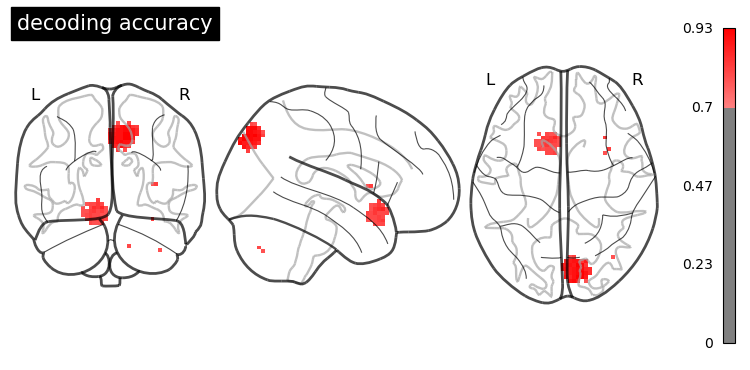

In [18]:
acc_threshold = 0.77
avg_scores_thr = np.where(results['avg_scores'] > acc_threshold, results['avg_scores'], 0) 

avg_scores_thr_vol = reshape_3d_img(mask, avg_scores_thr, output_nii=True)

plotting.plot_glass_brain(avg_scores_thr_vol, threshold=0.7, 
                          title='decoding accuracy', cmap='bwr',
                          colorbar=True)
plt.show()

/home/simwei/anaconda3/envs/fusl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



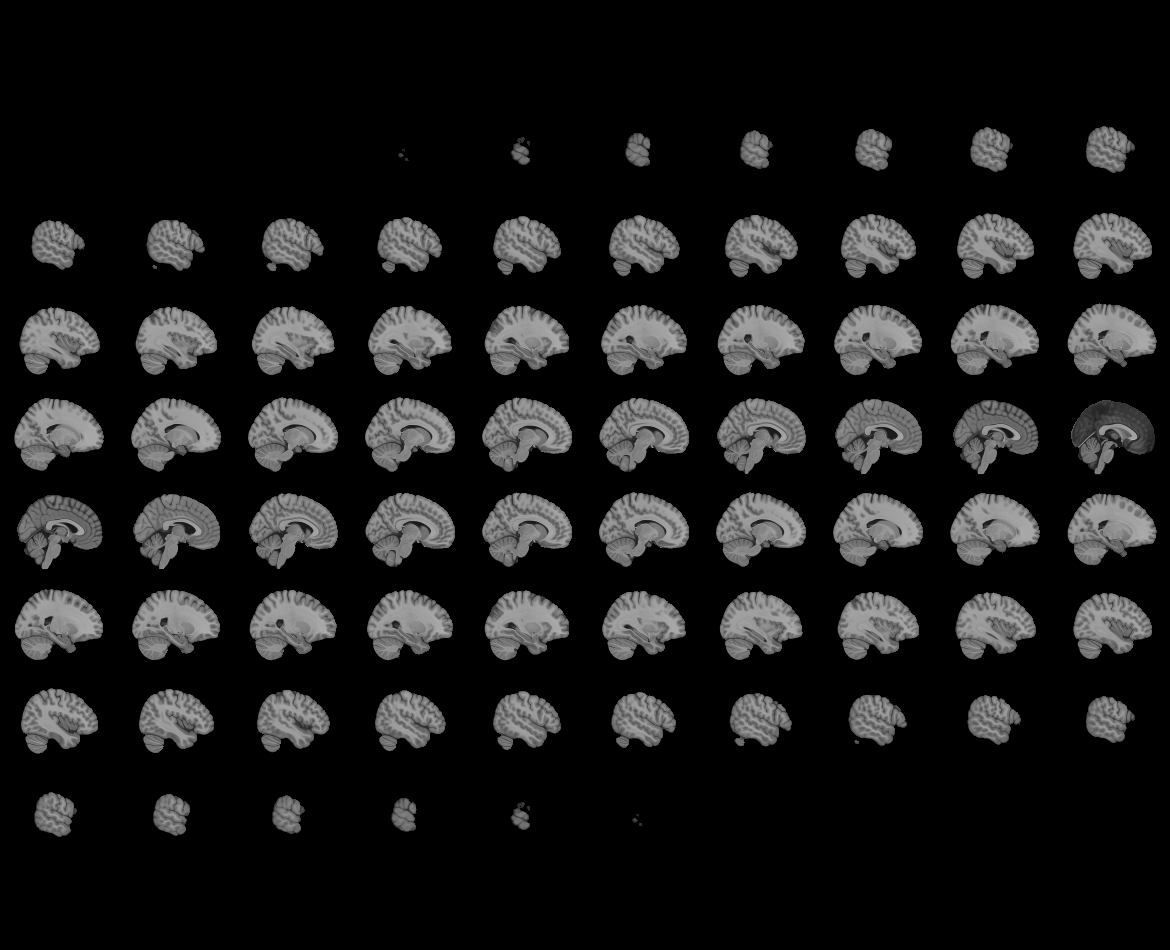
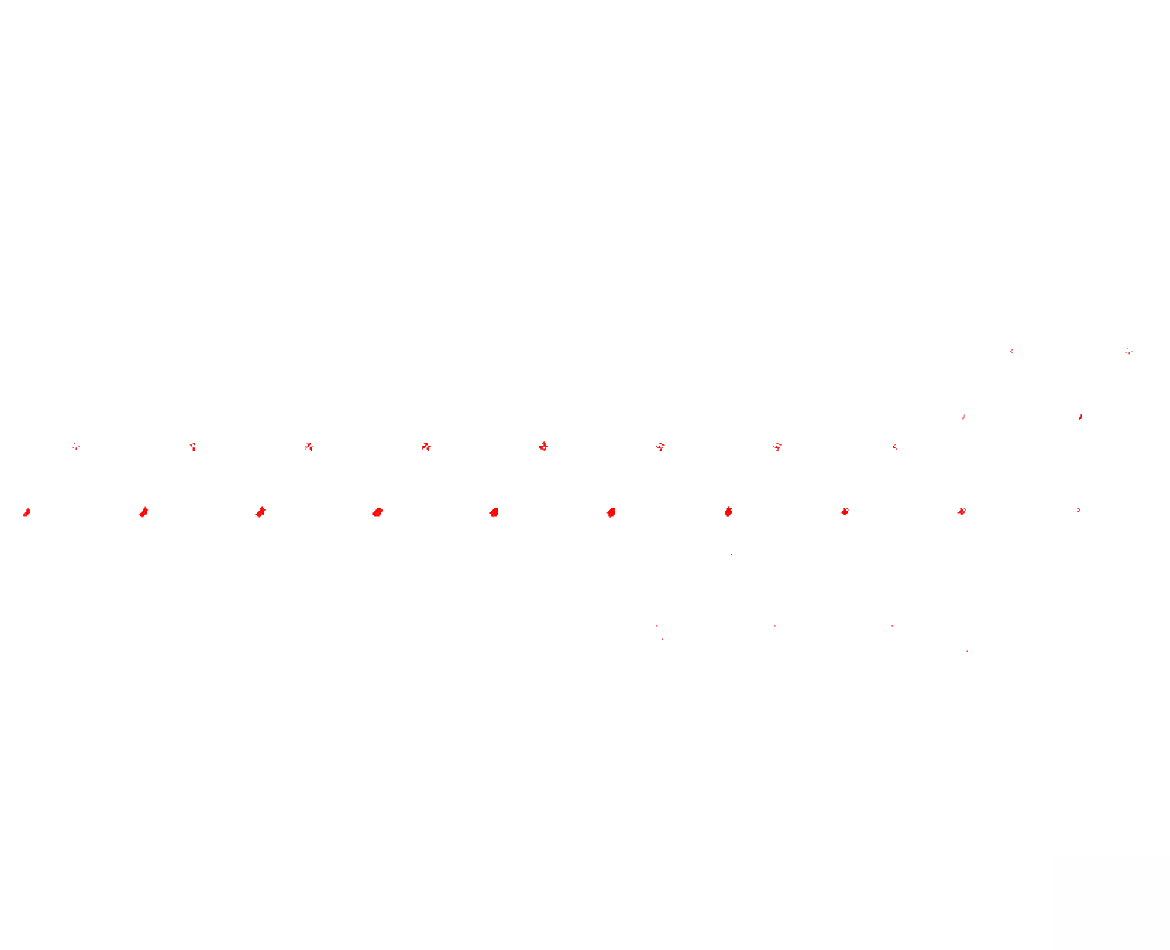

In [14]:
# Interactive plot.
html_view = plotting.view_img(avg_scores_thr_vol, threshold=0.1, vmax=None,
                              cut_coords=[8, -80, 44],
                              title='decoding accuracy', cmap='bwr')
html_view

If in our `fusion_search_light` function the computation of SHAP values was enabled (argument `shap=True`), we can then reconstruct the _importance_ of each individual input source. Our function output `results` contains then the mean absolute SHAP values of each searchlight (`results['shap_vals']`). We can average for each vertex these values across searchlights using the `compute_importance_maps` function. This generates for each source spatial maps of feature importance.

In [ ]:
# Re-run search light with shap=True.
# This can take some time when using google colab.
results = fusion_search_light(X=X,
                              y=y,
                              estimator=estimator,
                              A=fusl_adj,
                              cv=cv,
                              n_jobs=-1,
                              n_permutations=0,
                              shap=True)

In [ ]:
importance_maps = compute_importance_maps(shap_vals=results['shap_vals'], 
                                          sources=sl_sources, 
                                          neigh_adj=neigh_adj)

We can then weight these maps of feature _importance_ with the _informativeness_ at each vertex, by weighting the importance maps (`importance_maps`) with the thresholded decoding accuracy (`avg_scores_thr`).

In [ ]:
impact_maps = {}
for source in sources:
    impact = avg_scores_thr * importance_maps[source]
    impact_maps.update({source: impact})

/home/simwei/anaconda3/envs/fusl/lib/python3.11/site-packages/nilearn/plotting/img_plotting.py:1462: UserWarning: vmin is negative but plot_abs is True
  warnings.warn(


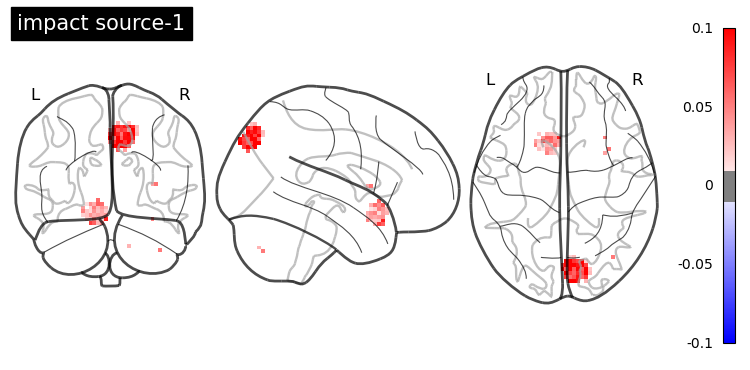

In [19]:
plt_source = 'source-1'  # Select one source for plotting.

impact_vol = reshape_3d_img(mask, impact_maps[plt_source], output_nii=True)

plotting.plot_glass_brain(impact_vol, threshold=0.01, vmin=-0.1, vmax=0.1,
                          title='impact {}'.format(plt_source), cmap='bwr',
                          colorbar=True)
plt.show()

/home/simwei/anaconda3/envs/fusl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



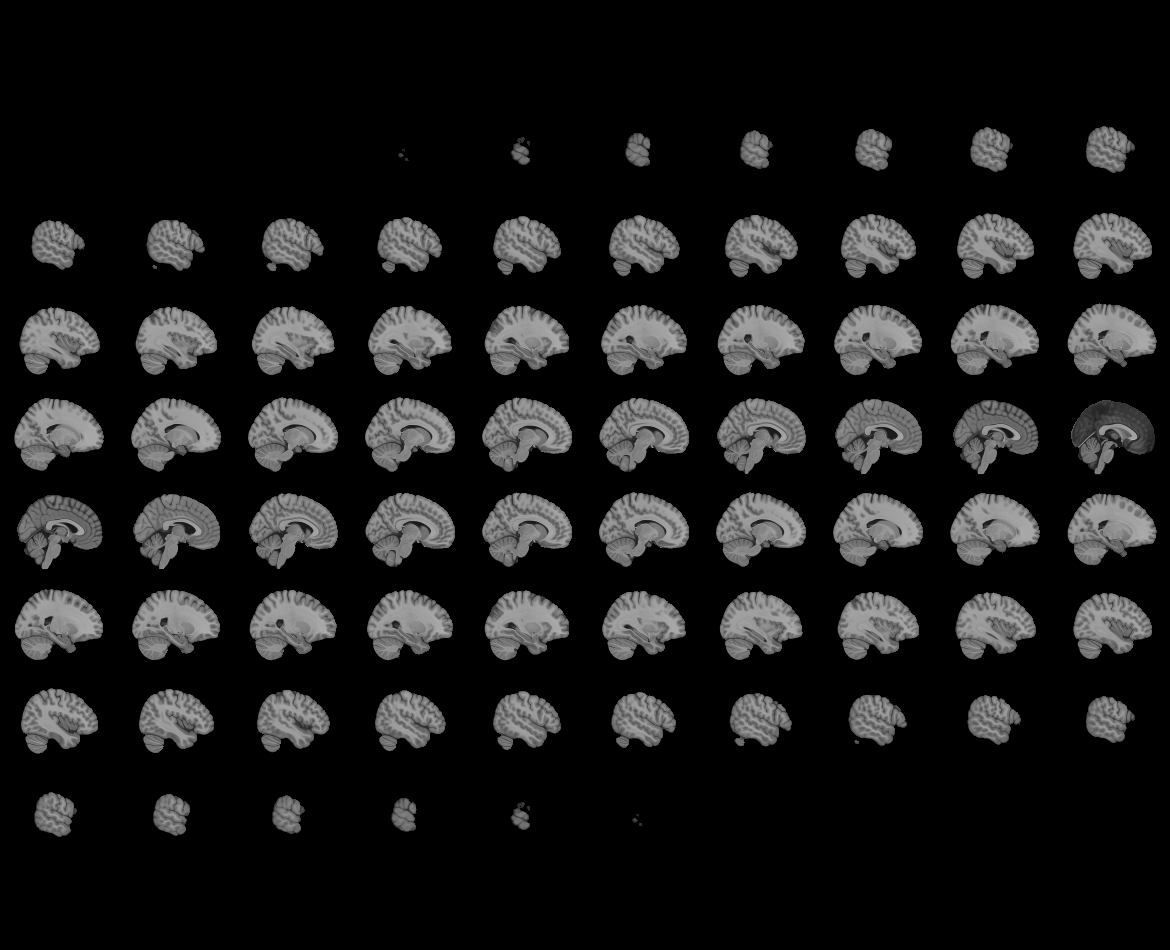
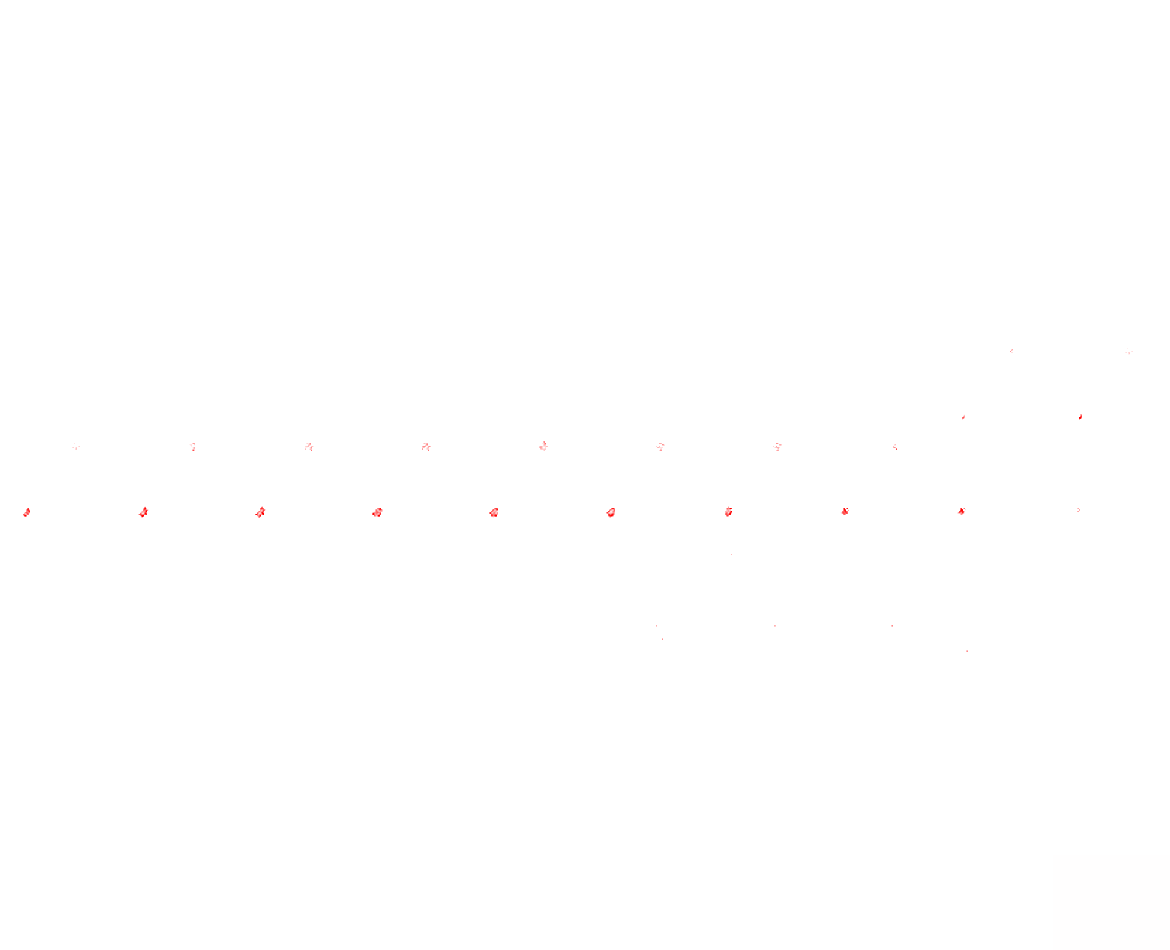

In [16]:
# Interactive plot.
html_view = plotting.view_img(impact_vol, threshold=0.01, vmax=0.1,
                              cut_coords=[8, -80, 44],
                              title='impact {}'.format(plt_source), cmap='bwr')
html_view

## Statistical testing.

To define, whether a decoding accuracy is statistically significant from chance, we can employ permutation testing. If `n_permutations > 0` the `fusion_search_light` function returns maps with accuracy scores, based on permuted labels (`results['perm_scores']`). <font color='red'>Note that this will be more time consuming!</font>

In [ ]:
n_permutations = 500

# Run search light again, with permutation testing enabled.
results = fusion_search_light(X=X, 
                              y=y, 
                              estimator=estimator,
                              A=fusl_adj, 
                              cv=cv, 
                              n_jobs=15,
                              n_permutations=n_permutations, 
                              shap=True)

To test for statistical significance and account for multiple comparisons across vertices we can utilize threshold-free cluster enhancement ([TFCE](https://www.fmrib.ox.ac.uk/datasets/techrep/tr08ss1/tr08ss1.pdf)) implemented in the `tfce_stats` function.

In [ ]:
# Compute tfce map and pvalues.
pvalues_tfce, scores_tfce = tfce_stats(scores=results['avg_scores'],
                                       permutation_scores=results['perm_scores'], 
                                       adj=mask_adjacency_mni(mask, radius=1, world_space=True))

We can then use the (TFCE corrected) p-values to threshold our accuracy maps again.

In [ ]:
avg_scores_thr_tfce = np.where(pvalues_tfce < 0.05, results['avg_scores'], 0) 

avg_scores_thr_tfce_vol = reshape_3d_img(mask, avg_scores_thr_tfce, output_nii=True)

plotting.plot_glass_brain(avg_scores_thr_tfce_vol, vmax=0.01,
                          title='statistically significant decoding accuracy', cmap='bwr',
                          colorbar=True)

In [ ]:
html_view = plotting.view_img(avg_scores_thr_tfce_vol, threshold=0.1, vmax=None,
                              cut_coords=[8, -80, 44],
                              title='statistically significant decoding accuracy', 
                              cmap='bwr')
html_view